In [1]:
import torch
import torchvision
import PIL
import numpy as np
import cppn

import matplotlib.pyplot as plt
import montage

%matplotlib inline
%load_ext autoreload

%autoreload 2

Target shape = torch.Size([1, 3, 224, 224])


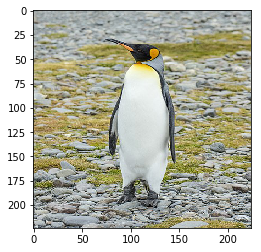

In [2]:
filename = 'penguin.jpg'
im_width = 224
im_size = (im_width, im_width)
target = montage.load_image(filename, im_size) # (w,h)
target = target/255
print(f"Target shape = {target.size()}")
montage.show(255*target)

In [47]:
from torchvision import models
model = models.vgg16(pretrained=True).features
model.eval()
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [109]:
class LearnableImage(torch.nn.Module):
    def __init__(self, size):
        super(LearnableImage, self).__init__()
        self.pixels = torch.nn.Parameter(0.1*torch.randn(1,3,size,size))
        
    def forward(self):
        #return self.pixels
        return torch.sigmoid(self.pixels)


In [49]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [133]:
class GramRecord():
    def __init__(self):
        self.value = None
        
    def hook(self, mod, hook_in, hook_out):
        conv_features = hook_out.clone()
        G = gram_matrix(conv_features)
        self.value = G
    
gram = GramRecord()
hook_ref = model[17].register_forward_hook(gram.hook)

In [134]:
def denormalise(in_tensor):
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    return in_tensor * std[None,:,None,None] + mean[None,:,None,None]
 
def normalise(in_tensor):
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    return (in_tensor - mean[None,:,None,None]) / std[None,:,None,None]
 

In [135]:
out = model(normalise(target))

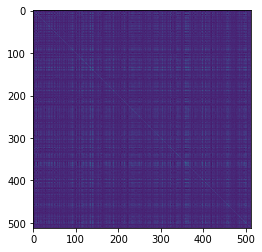

In [136]:
plt.imshow(gram.value.detach())
target_value = gram.value.detach()

In [ ]:
image = LearnableImage(256)
optimiser = torch.optim.Adam(image.parameters(), lr=10)
steps = 1000
jitter = 8
criterion = torch.nn.MSELoss()
for i in range(steps):
    optimiser.zero_grad()
    input_image = image()
    #input_image = torch.roll(input_image, 
    #                         np.random.randint(-jitter, jitter), 
    #                         dims=2)
    #input_image = torch.roll(input_image, 
    #                         np.random.randint(-jitter, jitter), 
    #                         dims=3)
    
    model(normalise(input_image))
    
    loss = criterion(gram.value, target_value)
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    optimiser.step()


montage.show(255*denormalise(image()))

tensor(6.2322e-05, grad_fn=<MseLossBackward>)
tensor(4.1106e-07, grad_fn=<MseLossBackward>)


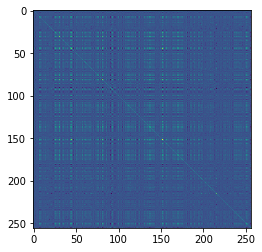

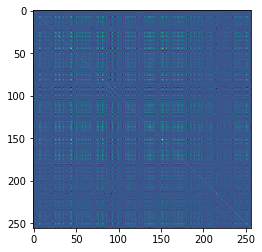

In [125]:
plt.imshow(gram.value.detach())
plt.show()
plt.imshow(target_value)
plt.show()
#plt.plot(1*denormalise(image()).detach().numpy().ravel()[:100])
#print(image.pixels.grad)

tensor(8.4133e-05, grad_fn=<MseLossBackward>)
tensor(7.7902e-05, grad_fn=<MseLossBackward>)
tensor(7.2365e-05, grad_fn=<MseLossBackward>)
tensor(6.7438e-05, grad_fn=<MseLossBackward>)
tensor(6.3018e-05, grad_fn=<MseLossBackward>)
tensor(5.9046e-05, grad_fn=<MseLossBackward>)
tensor(5.5457e-05, grad_fn=<MseLossBackward>)
tensor(5.2199e-05, grad_fn=<MseLossBackward>)
tensor(4.9228e-05, grad_fn=<MseLossBackward>)
tensor(4.6521e-05, grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


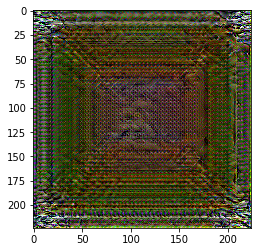

In [45]:
for i in range(steps):
    optimiser.zero_grad()
    input_image = image()
    out = model(normalise(input_image))
    
    loss = criterion(gram.value, target_value)
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    optimiser.step()

montage.show(255*image())

In [119]:
for idx, child in enumerate(model.children()):
    if isinstance(child, torch.nn.ReLU):
        model[idx] = torch.nn.ReLU(inplace=False)
    elif isinstance(child, torch.nn.MaxPool2d):
        model[idx] = torch.nn.AvgPool2d(kernel_size=child.kernel_size, stride=child.stride, padding=child.padding)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU()
  (21): Conv2d(512, 512

tensor(0.0035, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0001, grad_fn=<MseLossBackward>)
tensor(0.0001, grad_fn=<MseLossBackward>)
tensor(8.1863e-05, grad_fn=<MseLossBackward>)
tensor(6.9431e-05, grad_fn=<MseLossBackward>)
tensor(6.0900e-05, grad_fn=<MseLossBackward>)
tensor(5.4563e-05, grad_fn=<MseLossBackward>)
tensor(4.9670e-05, grad_fn=<MseLossBackward>)


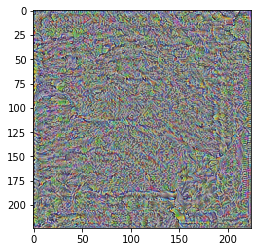

In [36]:
image = LearnableImage(224)
optimiser = torch.optim.Adam(image.parameters(), lr=0.1)
steps = 100
criterion = torch.nn.MSELoss()
for i in range(steps):
    optimiser.zero_grad()
    input_image = image()
    out = model(normalise(input_image))
    
    loss = criterion(gram.value, target_value)
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    optimiser.step()


montage.show(255*image())